In [1]:
import pandas as pd
from scipy.stats import entropy
import numpy as np
from PIL import Image
import requests
import torch
import re
import statistics
import ast
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

In [2]:
df = pd.read_excel("/home/student/HallucinationsLLM/data/team5_clean_dataset.xlsx", index_col=0)

In [3]:
def count_brackets(string):
    counter = 0
    for c in string: 
        if c == "[":
            counter += 1 
    return counter

def clean_text(text):
    # Remove specific substrings
    text = re.sub(r'<0x0A>', ' ', text)
    text = re.sub(r'</s>', '', text)
    # Remove any other unwanted patterns (adjust the regex if needed)
    text = re.sub(r'<[^>]*>', '', text)
    return text.strip()

def count_words(text):
    words = text.split()
    return len(words)


def first_brackets_index(text):
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            return i / len(words)
    return -1 

def extract_brackets_len(text):
    lens = []
    cleaned_text = clean_text(text)
    words = cleaned_text.split()
    for i, word in enumerate(words):
        if "[" in word:
            counter = 0
            for j in range(i, len(words)):
                counter += 1
                if "]" in words[j]:
                    break
            lens.append(counter)
    return lens

def get_words_dist(description, logits):
    cleaned_text = clean_text(description)
    words = cleaned_text.split()
    probs = {}
    print(len(words), len(logits))
    assert len(words) == len(logits)
    for word, prob_dict in zip(words, logits):
        probs[word] = prob_dict[word]
    return probs

cols_with_brackets = ['hallucinations', 'hedges', 'context_1', 'context_2', 'context_3', 'context_4']
for col in cols_with_brackets:
    df[f'{col}_count'] = df[col].apply(lambda x: count_brackets(x))

df['logits'] = df['logits'].apply(lambda x: ast.literal_eval(x))
df['clean_description'] = df['description'].apply(clean_text)
df['description_len'] = df['clean_description'].apply(count_words)
df['first_hal_index'] = df['hallucinations'].apply(first_brackets_index)
df['hal_lens'] = df['hallucinations'].apply(extract_brackets_len)

Text(0.5, 1.0, '#Hallucinations Distriubtion')

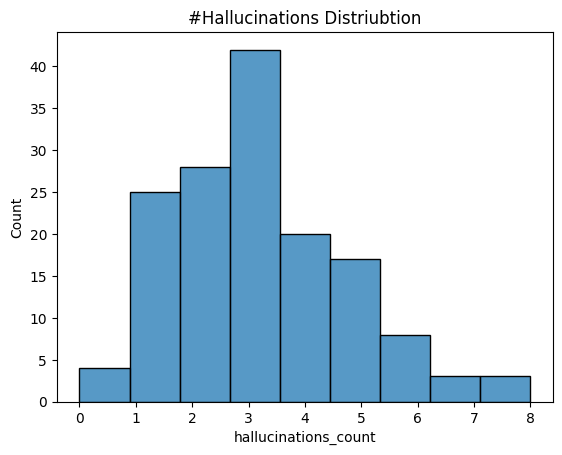

In [4]:
sns.histplot(data=df, x='hallucinations_count', bins=9)
plt.title("#Hallucinations Distriubtion")

Text(0.5, 1.0, 'First Hallucination normalized Location Distribution')

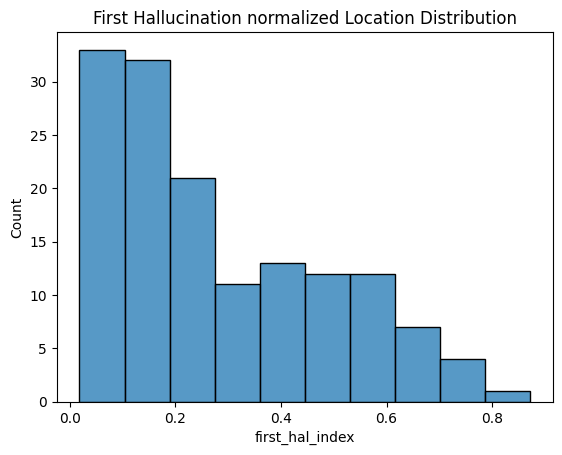

In [5]:
filtered_df = df[df['first_hal_index'] != -1]
sns.histplot(data=filtered_df, x='first_hal_index', bins=10)
plt.title("First Hallucination normalized Location Distribution")

In [6]:
print(pearsonr(df['description_len'], df['hallucinations_count']))
print(pearsonr(df['hedges_count'], df['hallucinations_count']))

PearsonRResult(statistic=np.float64(0.2942472875120372), pvalue=np.float64(0.0002572980447021))
PearsonRResult(statistic=np.float64(0.0998099431311304), pvalue=np.float64(0.22427909896423073))


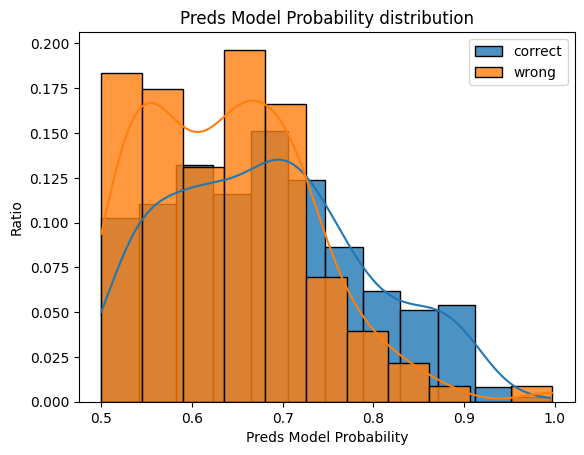

In [10]:
new_data = {
    'probe_number': [],
    'pred': [],
    'label': [],
    'prob': []
}

# Loop through each column group and append to new_data
for i in range(1, 5):
    new_data['probe_number'].extend([i] * len(df))
    new_data['pred'].extend(df[f'pred_{i}'])
    new_data['label'].extend(df[f'label_{i}'])
    new_data['prob'].extend(df[f'pred_{i}_prob'])

# Create the new DataFrame
new_df = pd.DataFrame(new_data)
new_df['correct_pred'] = (new_df['pred'] == new_df['label']).astype(int)
correct_df = new_df[new_df['correct_pred'] == 1]
wrong_df = new_df[new_df['correct_pred'] == 0]

sns.histplot(data=correct_df, x="prob", kde=True, stat='probability', label="correct", alpha=0.8)
sns.histplot(data=wrong_df, x="prob", kde=True, stat='probability', label="wrong", alpha=0.8)
plt.legend()
plt.xlabel('Preds Model Probability')
plt.ylabel('Ratio')
plt.title("Preds Model Probability distribution")
plt.show()

### Analyze logits

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

def prepare_stopwords_set():
    stop_words = set(stopwords.words('english'))
    for punc in string.punctuation:
        stop_words.add(punc)
    return stop_words

stop_words_set = prepare_stopwords_set()
custom_stop_words = (stop_words_set - {'above', 'all', 'any', 'are', "aren't", 'between', 'below', 'before', 'both', 'down', 'few',
                                       'each', 'from', 'further', 'he', 'her', 'here', 'hers', 'him', 'his', 'in', 'into',  'is', 'isn',
                                        "isn't", 'it', "it's", 'its', 'itself', 'most', 'no', 'not', 'on', 'of', 'off', 'only', 'once', 'other', 'over', 'out',
                                        'some', 'their', 'theirs', 'them', 'they', 'there', 'to', 'too', 'was', "wasn't", 'we', 'were', "weren't", ']', '['}).union(
                                    {'although', 'as', 'because', 'so', 'supposing', 'suggesting', 'additionally', 'that', 'than', 'though', 'till',
                                      'unless', 'until', 'when', 'whenever', 'accordingly', 'also', 'consequently', 'conversely', 'furthermore', 'finally', 'hence',
                                      'however', 'indeed', 'likewise', 'meanwhile', 'moreover', 'nevertheless', 'nonetheless', 'otherwise', 'similarly', 'therefore', 'thus'
                                    'whereas', 'wherever', 'whether', 'while', 'either', 'neither', 'but', 'yet'})

custom_stop_words

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '\\',
 '^',
 '_',
 '`',
 'a',
 'about',
 'accordingly',
 'additionally',
 'after',
 'again',
 'against',
 'ain',
 'also',
 'although',
 'am',
 'an',
 'and',
 'aren',
 'as',
 'at',
 'be',
 'because',
 'been',
 'being',
 'but',
 'by',
 'can',
 'consequently',
 'conversely',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'during',
 'either',
 'finally',
 'for',
 'furthermore',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'hence',
 'herself',
 'himself',
 'how',
 'however',
 'i',
 'if',
 'indeed',
 'just',
 'likewise',
 'll',
 'm',
 'ma',
 'me',
 'meanwhile',
 'mightn',
 "mightn't",
 'more',
 'moreover',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'neither',
 'nevertheless',
 'nonetheless',
 'nor',
 'now',
 'o'

In [8]:
def map_words_logits(logits, description):
    pattern = r'<0x0A>|</s>'
    cleaned_description = re.sub(pattern, ' ', description)
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()
    words = cleaned_description.split(" ")
    words_logits_indices = []
    idx = 0 
    words_token = ""
    idx_list = []
    flag = False
    for i, (token, prob_dict) in enumerate(logits):
        if ">" == token[-1]:
            flag = False
            continue
        if "<" in token:
            flag = True
        if flag:
            continue
        
        if token.strip() == ".":
            continue
        if words[idx][-1] == "." and token.strip()[-1] != ".":
            word = words[idx][:-1]
        else:
            if "." in words[idx]: 
                print(words[idx])
            word = words[idx]
        # print(i, idx, token.strip(), word, words_token)
        if token.strip() == word:
            words_logits_indices.append((word.replace(".", ""), [i]))
            idx += 1 
        else:
            words_token += token.strip()
            idx_list.append(i)
            if words_token == word:
                words_logits_indices.append((word.replace(".", ""), idx_list))
                words_token = ""
                idx_list = []
                idx += 1 
    return words_logits_indices


def get_in_out_indices(sentences, demo=False):
    random.seed(42)
    results = []
    for sentence in sentences:
        in_indices = []
        out_indices = []
        words = sentence.split()
        in_brackets = False
        for i, word in enumerate(words):
            if '[' in word:
                in_brackets = True
            if ']' in word:
                in_brackets = False

            if in_brackets or '[' in word or ']' in word:
                in_indices.append(i)
            else:
                out_indices.append(i)
        if not demo: 
            results.append({'in': in_indices, 'out': out_indices})
        else:
            random_start_index = random.randint(0, len(words) - len(in_indices))
            random_in_indices = [random_start_index + i for i in range(len(in_indices))]
            # random_in_indices = random.sample(len(words) - len(in_indices))
            random_out_indices = list(set(range(len(words))) - set(random_in_indices))
            results.append({'in': random_in_indices, 'out': random_out_indices})
    return results


def get_part_probs_list(indices, words_logits_mapping, logits, counter, stop_words_set,use_entropy=False):
    probs = []
    for j in indices:
        try:
            word_item = words_logits_mapping[j + counter]
        except:
            print("In exception")
            print(words_logits_mapping)
            print(len(words_logits_mapping), j + counter)
            return None
        word = word_item[0]
        if word in stop_words_set:
            continue
        prob_idx = word_item[1][0]
        if use_entropy:
            prob = entropy(list(logits[prob_idx][1].values()), base=2) 
        else:
            prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
        
        # prob_idx_list = word_item[1]
        # prob = 1
        # for prob_idx in prob_idx_list:
        #     if len(prob_idx_list) > 1:
        #         print(logits[prob_idx][0], logits[prob_idx][1][logits[prob_idx][0].strip()])
        #     prob *= logits[prob_idx][1][logits[prob_idx][0].strip()]
        probs.append(prob)
    return probs


def extract_hals_probs(logits, words_logits_mapping, hallucinations, stop_words_set, use_entropy=False, demo=False):
    pattern = r'<0x0A>|</s>'
    cleaned_hallucinations = re.sub(pattern, ' ', hallucinations)
    cleaned_hallucinations = re.sub(r'\s+', ' ', cleaned_hallucinations).strip()
    sentences = cleaned_hallucinations.split(".")[:-1]
    in_out_probs_list = []
    counter = 0 
    in_out_indices = get_in_out_indices(sentences, demo=demo)
    for in_out_dict, sentence in zip(in_out_indices, sentences): 
        words = sentence.split()
        sentence_dict = {"out": {"min": None, "max": None, "mean": None, "median": None}, "in": {"min": None, "max": None, "mean": None, "median": None}}
        # in part 
        in_indices = in_out_dict['in']
        if len(in_indices) > 0:
            in_probs = get_part_probs_list(in_indices, words_logits_mapping, logits, counter, stop_words_set, use_entropy=use_entropy)
            if len(in_probs) > 0:
                sentence_dict["in"]["min"] = min(in_probs)
                sentence_dict["in"]["max"] = max(in_probs)
                sentence_dict["in"]["mean"] = sum(in_probs) / len(in_probs)
                sentence_dict["in"]["median"] = statistics.median(in_probs)

        # out part 
        out_indices = in_out_dict['out']
        if len(out_indices) > 0:
            out_probs = get_part_probs_list(out_indices, words_logits_mapping, logits, counter, stop_words_set, use_entropy=use_entropy)
            if len(out_probs) > 0:
                sentence_dict["out"]["min"] = min(out_probs)
                sentence_dict["out"]["max"] = max(out_probs)
                sentence_dict["out"]["mean"] = sum(out_probs) / len(out_probs)
                sentence_dict["out"]["median"] = statistics.median(out_probs)
            

        counter += len(words)
        in_out_probs_list.append(sentence_dict)
    return in_out_probs_list

In [11]:
def get_probs(in_out_probs):
    res_dict = {"min": [], "max": [], "mean": [], "median": []}
    for probs_dict in in_out_probs:
        if None in list(probs_dict.values())[0].values() or None in list(probs_dict.values())[1].values():
            continue
        res_dict["min"].append(np.log(probs_dict['out']['min']) / np.log(probs_dict['in']['min']))
        res_dict["max"].append(np.log(probs_dict['out']['max']) / np.log(probs_dict['in']['max']))
        res_dict["mean"].append(np.log(probs_dict['out']['mean']) / np.log(probs_dict['in']['mean']))
        res_dict["median"].append(np.log(probs_dict['out']['median']) / np.log(probs_dict['in']['median']))
    return res_dict


def get_probs_by_name(in_out_probs, name):
    res_dict = {"min": [], "max": [], "mean": [], "median": []}
    for probs_dict in in_out_probs:
        if None in list(probs_dict.values())[0].values() or None in list(probs_dict.values())[1].values():
            continue
        res_dict["min"].append(probs_dict[name]['min'])
        res_dict["max"].append(probs_dict[name]['max'])
        res_dict["mean"].append(probs_dict[name]['mean'])
        res_dict["median"].append(probs_dict[name]['median'])
    return res_dict


df['words_logits_mapping'] = df.apply(lambda row: map_words_logits(row['logits'], row['description']), axis=1)
df['in_out_probs'] = df.apply(lambda row: extract_hals_probs(row['logits'], row['words_logits_mapping'], row['hallucinations'], custom_stop_words, use_entropy=True), axis=1)
df['in_out_random_probs'] = df.apply(lambda row: extract_hals_probs(row['logits'], row['words_logits_mapping'], row['hallucinations'], stop_words_set, use_entropy=True, demo=True), axis=1)

df['in_out_pairs_ratio_probs'] = df['in_out_probs'].apply(get_probs)
df['out_probs'] = df['in_out_probs'].apply(lambda x: get_probs_by_name(x, "out"))
df['in_probs'] = df['in_out_probs'].apply(lambda x: get_probs_by_name(x, "in"))
df['out_random_probs'] = df['in_out_random_probs'].apply(lambda x: get_probs_by_name(x, "out"))
df['in_random_probs'] = df['in_out_random_probs'].apply(lambda x: get_probs_by_name(x, "in"))

coffee).


/tmp/ipykernel_22799/1317946811.py:6: RuntimeWarning: divide by zero encountered in log
  res_dict["min"].append(np.log(probs_dict['out']['min']) / np.log(probs_dict['in']['min']))


In [12]:
def statistical_test(agg_metric, df, temps, demo=False):
    if demo:
        col_suffix = "random_probs"
    else:
        col_suffix = "probs"
    unified_in_dict = {"min": [], "max": [], "mean": [], "median": []}
    unified_out_dict = {"min": [], "max": [], "mean": [], "median": []}
    df_temp = df[df['temperature'].isin(temps)]
    for index, row in df_temp.iterrows():
        for key in unified_in_dict.keys():
            unified_in_dict[key].extend(row[f'in_{col_suffix}'][key])
            unified_out_dict[key].extend(row[f'out_{col_suffix}'][key])
    
    metric_in_list = unified_in_dict[agg_metric]
    metric_out_list = unified_out_dict[agg_metric]
    stat, p_value = stats.wilcoxon(metric_in_list, metric_out_list)
    print(f"Statistic: {stat}, p-value: {p_value}")

    data = pd.DataFrame({'In': metric_in_list, 'Out': metric_out_list})
    data_melted = data.melt(var_name='Type', value_name='Probability')
    sns.boxplot(x='Type', y='Probability', data=data_melted)
    plt.title(f"{agg_metric} probabilities inside and outside the hallucinations")
    plt.show()


### Entropy

Statistic: 20609.0, p-value: 6.143454960403534e-09


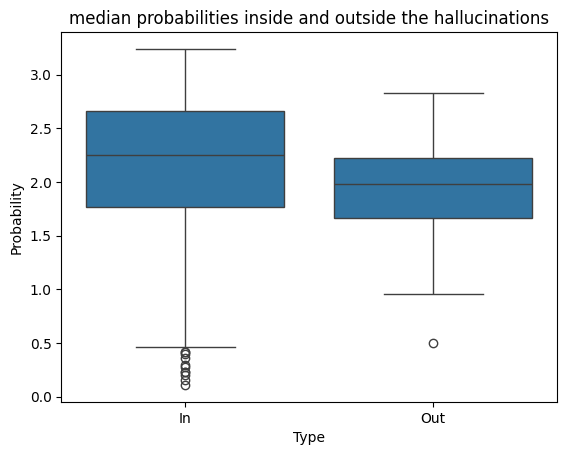

Statistic: 18790.0, p-value: 0.8077256791232734


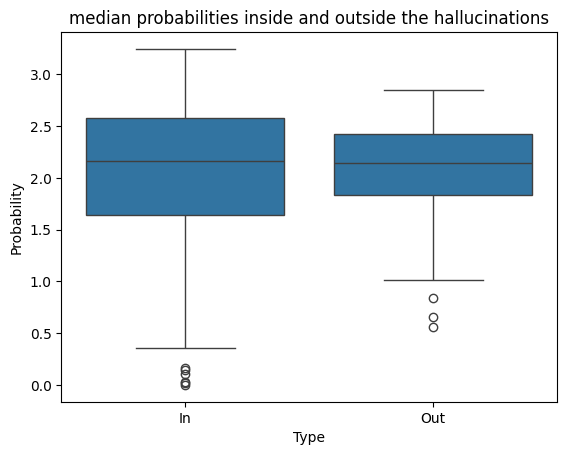

In [145]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1])
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1], demo=True)

### Probs

Statistic: 16183.0, p-value: 6.421571632579422e-16


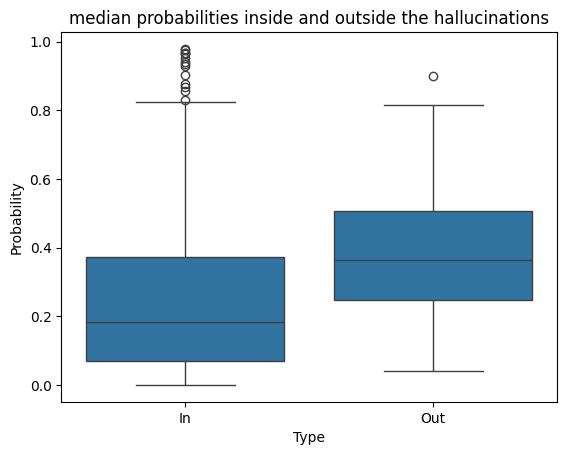

In [121]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1])

Statistic: 17359.5, p-value: 0.18644902007574526


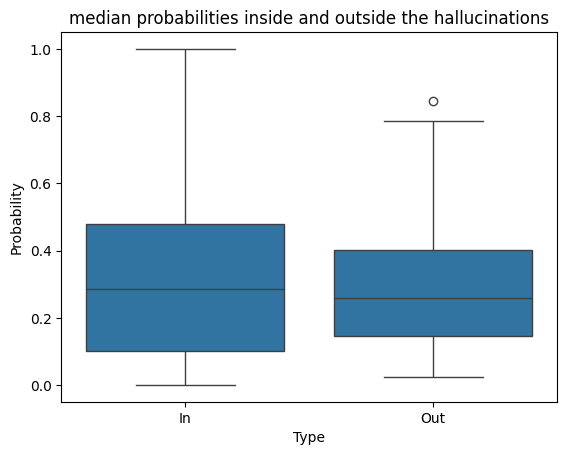

In [122]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1], demo=True)

### Before Stopwords Removal

Statistic: 12425.0, p-value: 5.209838222915902e-24


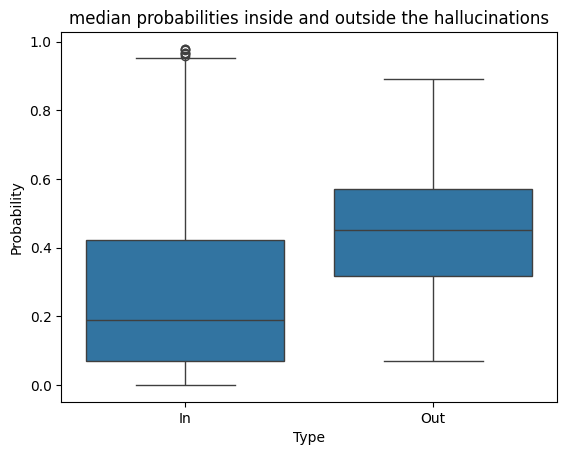

In [53]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1])

Statistic: 29202.0, p-value: 0.11421800907268449


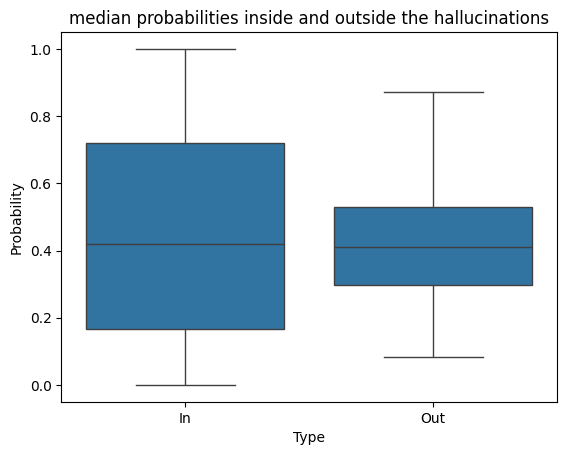

In [54]:
statistical_test(agg_metric="median", df=df, temps=[0.8, 0.9, 1], demo=True)

### Logits Heuristic

In [13]:
def hal_count_wa_stop_words(hallucination):
    words = hallucination.split()
    cleaned_words = [word for word in words if word not in custom_stop_words]
    cleaned_hallucination = ' '.join(cleaned_words) 
    return extract_brackets_len(cleaned_hallucination)

In [14]:
clean_hal_lens = df['hallucinations'].apply(hal_count_wa_stop_words).values.tolist()
clean_hal_lens_flattened = [item for sublist in clean_hal_lens for item in sublist]
pd.Series(clean_hal_lens_flattened).value_counts()

1    351
2     70
3     23
4      9
5      5
7      3
6      3
8      1
Name: count, dtype: int64

In [15]:
def get_in_out_indices_sep(sentences):
    results = []
    for sentence in sentences:
        in_list_indices = []
        out_list_indices = []
        words = sentence.split()
        in_brackets = False
        for i, word in enumerate(words):
            if '[' in word:
                in_brackets = True
                in_indices = []
            if ']' in word:
                in_brackets = False
                in_indices.append(i)
                in_list_indices.append(in_indices)
                out_list_indices.append([item for item in range(len(words)) if item not in in_indices])

            if in_brackets:
                in_indices.append(i)

        results.append({'in': in_list_indices, 'out': out_list_indices})
    return results


def get_part_probs_list_sep(indices, words_logits_mapping, logits, counter, stop_words_set):
    probs = []
    for j in indices:
        try:
            word_item = words_logits_mapping[j + counter]
        except:
            print("In exception")
            print(words_logits_mapping)
            print(len(words_logits_mapping), j + counter)
            return None
        word = word_item[0]
        if word in stop_words_set:
            continue
        prob_idx = word_item[1][0]
        prob = logits[prob_idx][1][logits[prob_idx][0].strip()]
        probs.append(prob)
    return probs


def extract_hals_probs_sep(logits, words_logits_mapping, hallucinations, stop_words_set):
    pattern = r'<0x0A>|</s>'
    cleaned_hallucinations = re.sub(pattern, ' ', hallucinations)
    cleaned_hallucinations = re.sub(r'\s+', ' ', cleaned_hallucinations).strip()
    sentences = cleaned_hallucinations.split(".")[:-1]
    in_out_probs_list = []
    counter = 0 
    in_out_indices = get_in_out_indices_sep(sentences)
    for in_out_dict, sentence in zip(in_out_indices, sentences): 
        words = sentence.split()
        sentence_dict = {"out": [], "in": [], "combined": []}
        # in part 
        in_indices_list = in_out_dict['in']
        for in_indices in in_indices_list:
            if len(in_indices) > 0:
                in_probs = get_part_probs_list_sep(in_indices, words_logits_mapping, logits, counter, stop_words_set)
                if len(in_probs) > 0:
                    sentence_dict["in"].append({"mean": sum(in_probs) / len(in_probs), "median": statistics.median(in_probs), "len": len(in_probs)})

        # out part 
        out_indices_list = in_out_dict['out']
        for out_indices in out_indices_list:
            if len(out_indices) > 0:
                out_probs = get_part_probs_list_sep(out_indices, words_logits_mapping, logits, counter, stop_words_set)
                if len(out_probs) > 0:
                    sentence_dict["out"].append({"mean": sum(out_probs) / len(out_probs), "median": statistics.median(out_probs), "len": len(out_probs)})


        for out_indices, in_indices in zip(out_indices_list, in_indices_list):
            if len(in_indices) > 0 and len(out_indices) > 0:
                in_probs = get_part_probs_list_sep(in_indices, words_logits_mapping, logits, counter, stop_words_set)
                out_probs = get_part_probs_list_sep(out_indices, words_logits_mapping, logits, counter, stop_words_set)
                if len(in_probs) > 0 and len(out_probs) > 0:
                    sentence_dict['combined'].append({'median_ratio': statistics.median(out_probs) / statistics.median(in_probs), 
                                                    'median_diff': statistics.median(out_probs) - statistics.median(in_probs), 
                                                    'len': len(in_probs)})
        counter += len(words)
        in_out_probs_list.append(sentence_dict)
    return in_out_probs_list

In [16]:
df['in_out_probs_sep'] = df.apply(lambda row: extract_hals_probs_sep(row['logits'], row['words_logits_mapping'], row['hallucinations'], custom_stop_words), axis=1)

In [28]:
in_out_statistics = {"in": {"median": [], "mean": [], "len": []}, "out": {"median": [], "mean": [], "len": []}, "combined": {"median_ratio": [], "median_diff": [], "len": []}}
for i in range(len(df)):
    in_out_dict_list = df['in_out_probs_sep'].iloc[i]
    for in_out_dict in in_out_dict_list:
        for key, lst in in_out_dict.items():
            for stats_dict in lst:
                if key in ["in", "out"]:
                    in_out_statistics[key]["median"].append(stats_dict["median"])
                    in_out_statistics[key]["mean"].append(stats_dict["mean"])
                else:
                    in_out_statistics[key]["median_ratio"].append(stats_dict["median_ratio"])
                    in_out_statistics[key]["median_diff"].append(stats_dict["median_diff"])
                in_out_statistics[key]["len"].append(stats_dict["len"])

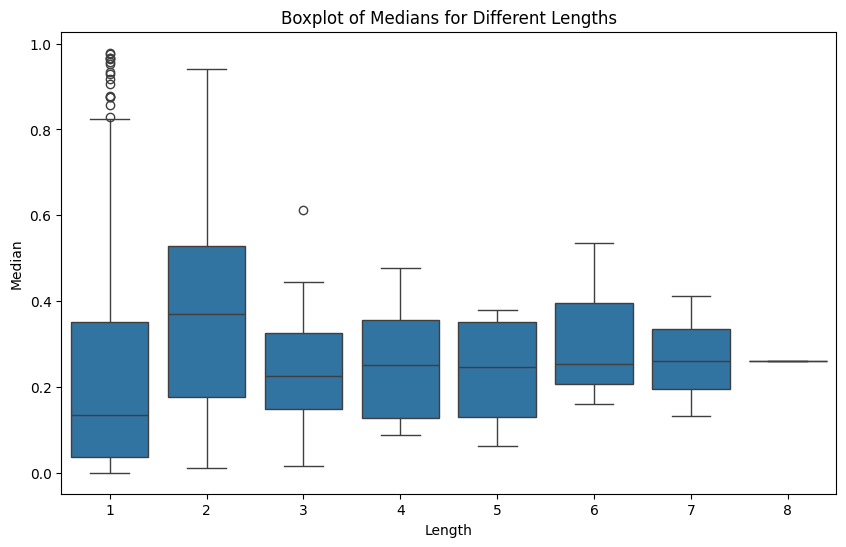

In [29]:
data = pd.DataFrame({'len': in_out_statistics["in"]['len'],
                      'median': in_out_statistics["in"]['median'],
                        'mean': in_out_statistics["in"]['mean']})

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='len', y='median', data=data)
plt.title('Boxplot of Medians for Different Lengths')
plt.suptitle('')  # Suppress the automatic title
plt.xlabel('Length')
plt.ylabel('Median')
plt.show()

In [84]:
stats = data.groupby('len')['median'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
len,,,,,,,,
1,352.0,0.231843,0.256124,0.00020,0.036775,0.13370,0.352300,0.97880
2,67.0,0.370392,0.231142,0.01005,0.175925,0.37060,0.527800,0.94070
3,22.0,0.246418,0.152948,0.01670,0.148600,0.22640,0.326825,0.61190
4,10.0,0.259490,0.145840,0.08785,0.126962,0.25130,0.355475,0.47715
5,4.0,0.234375,0.151972,0.06310,0.129250,0.24705,0.352175,0.38030
6,3.0,0.317117,0.195557,0.16050,0.207525,0.25455,0.395425,0.53630
7,3.0,0.267933,0.139744,0.13200,0.196300,0.26060,0.335900,0.41120
8,1.0,0.259650,NaN,0.25965,0.259650,0.25965,0.259650,0.25965


In [119]:
stats = data.groupby('len')['mean'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
len,,,,,,,,
1,352.0,0.231843,0.256124,0.000200,0.036775,0.133700,0.352300,0.978800
2,67.0,0.370392,0.231142,0.010050,0.175925,0.370600,0.527800,0.940700
3,22.0,0.346479,0.132450,0.067300,0.324900,0.345333,0.394925,0.598200
4,10.0,0.319197,0.143062,0.154925,0.171125,0.352225,0.401875,0.527800
5,4.0,0.327445,0.057929,0.263580,0.292530,0.323970,0.358885,0.398260
6,3.0,0.365911,0.096548,0.295000,0.310933,0.326867,0.401367,0.475867
7,3.0,0.385581,0.070245,0.314314,0.350993,0.387671,0.421214,0.454757
8,1.0,0.397338,NaN,0.397338,0.397338,0.397338,0.397338,0.397338


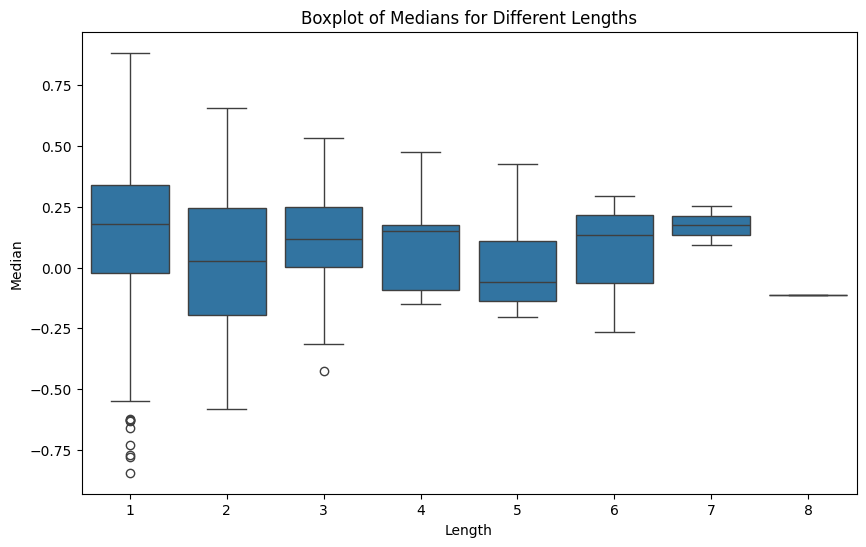

In [31]:
data = pd.DataFrame({'len': in_out_statistics["combined"]['len'],
                      'median_ratio': in_out_statistics["combined"]["median_ratio"],
                      'median_diff': in_out_statistics["combined"]["median_diff"]})

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='len', y='median_diff', data=data)
plt.title('Boxplot of Medians for Different Lengths')
plt.suptitle('')  # Suppress the automatic title
plt.xlabel('Length')
plt.ylabel('Median')
plt.show()

In [32]:
stats = data.groupby('len')['median_diff'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
len,,,,,,,,
1,352.0,0.142501,0.305903,-0.84345,-0.023975,0.17925,0.340200,0.88340
2,67.0,0.030278,0.306757,-0.58345,-0.195100,0.02655,0.246375,0.65570
3,22.0,0.114709,0.258254,-0.42490,0.001925,0.11675,0.250387,0.53220
4,10.0,0.107080,0.206221,-0.14835,-0.090450,0.14955,0.176825,0.47670
5,4.0,0.026325,0.278921,-0.20455,-0.139037,-0.05755,0.107813,0.42495
6,3.0,0.054900,0.287370,-0.26375,-0.064850,0.13405,0.214225,0.29440
7,2.0,0.173900,0.112854,0.09410,0.134000,0.17390,0.213800,0.25370
8,1.0,-0.112150,NaN,-0.11215,-0.112150,-0.11215,-0.112150,-0.11215


In [33]:
stats = data.groupby('len')['median_ratio'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
len,,,,,,,,
1,352.0,32.155755,139.715066,0.099833,0.924837,2.633712,9.137650,1678.500000
2,67.0,3.801603,8.121792,0.130132,0.603585,1.049352,2.376619,44.691525
3,22.0,4.074222,7.551397,0.179277,1.008658,1.584178,2.812953,32.497006
4,10.0,1.795079,1.094589,0.599000,0.897271,1.582892,2.324518,4.195040
5,4.0,2.467168,3.519005,0.462135,0.609116,0.835995,2.694047,7.734548
6,3.0,1.623029,1.166025,0.508204,1.017410,1.526616,2.180442,2.834268
7,2.0,2.141530,1.103709,1.361090,1.751310,2.141530,2.531750,2.921970
8,1.0,0.568072,NaN,0.568072,0.568072,0.568072,0.568072,0.568072


In [20]:
def extract_sentence_hals_labels(hallucinations):
    sentences = hallucinations.split(".")[:-1]
    labels = []
    for sentence in sentences:
        if "[" in sentence:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [37]:
def extract_sentence_hals_index(hallucinations):
    sentences = hallucinations.split(".")[:-1]
    sentences_indexes = []
    first_hal = -1 
    for i, sentence in enumerate(sentences):
        if "[" in sentence:
            sentences_indexes.append(i+1)

    for i, sentence in enumerate(sentences):
        if "[" in sentence:
            first_hal = i
            break
    return pd.Series([sentences_indexes, first_hal, len(sentences)])

<Axes: >

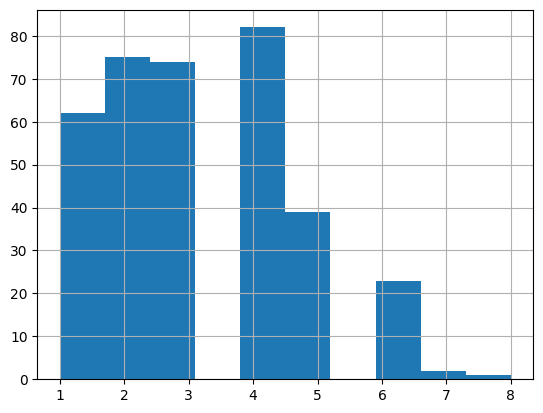

In [38]:
df[['sentence_hals_index', 'first_hal_sentence', 'sentences_num']] = df['hallucinations'].apply(extract_sentence_hals_index)
df['sentence_hals_index'].explode().hist()

<Axes: >

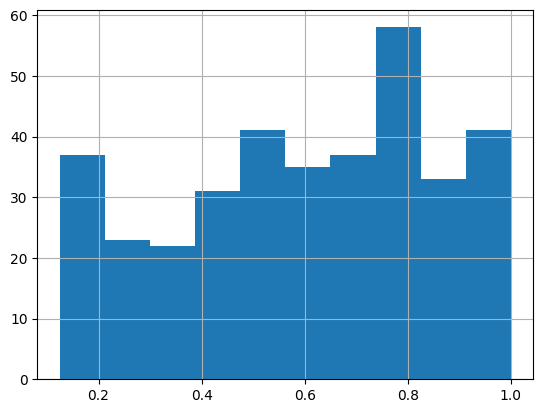

In [39]:
sentences_indexes_exploded = df[['sentence_hals_index', 'sentences_num']].explode('sentence_hals_index')
(sentences_indexes_exploded['sentence_hals_index'] / sentences_indexes_exploded['sentences_num']).hist()

<Axes: >

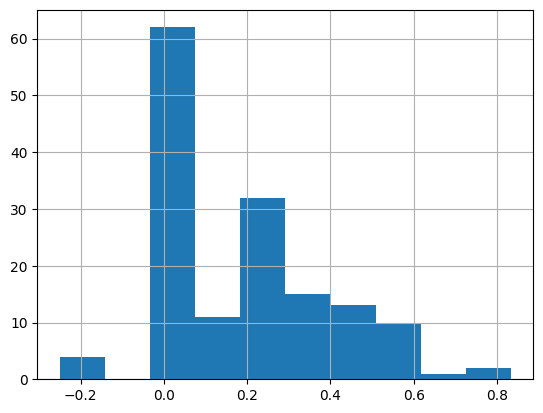

In [42]:
(df['first_hal_sentence'] / df['sentences_num']).hist()

### Extract Image Features

In [3]:
import cv2
def read_image_from_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype="uint8")
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return image

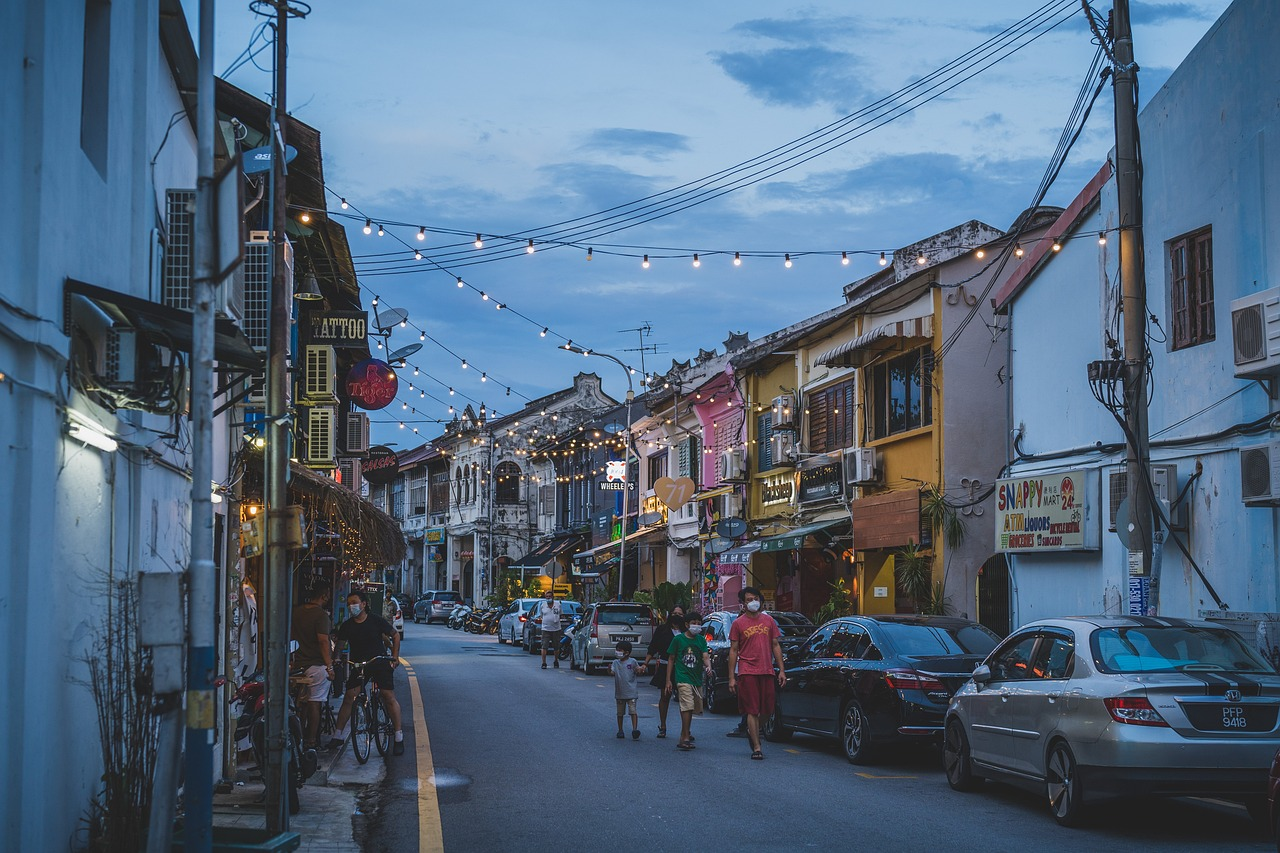

In [32]:
Image.open(requests.get(df['image_link'].iloc[0], stream=True).raw)

In [31]:
from ultralytics import YOLO

model = YOLO("yolov10x.pt")

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    classes_num = results[0].boxes.cls
    classes_names = results[0].names
    return [classes_names[int(num)] for num in classes_num]

image = read_image_from_url(df['image_link'].iloc[0])
results = predict(model, image, classes=[], conf=0.5)
results


0: 448x640 8 persons, 1 bicycle, 5 cars, 59.5ms
Speed: 2.4ms preprocess, 59.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


['car',
 'car',
 'person',
 'person',
 'person',
 'person',
 'person',
 'car',
 'car',
 'bicycle',
 'person',
 'person',
 'person',
 'car']

In [35]:
# Load the image
for i in range(len(df)):
    image = read_image_from_url(df['image_link'].iloc[i])

    # Split the image into its BGR channels
    (B, G, R) = cv2.split(image)

    # Calculate the mean of each channel
    mean_B = np.mean(B)
    mean_G = np.mean(G)
    mean_R = np.mean(R)

    print(mean_B, mean_G, mean_R)

124.80915793522861 102.9101324369871 81.99046014067996
116.56909528868698 116.63627179806565 118.50549897420868
105.82837109375 73.9500986328125 61.49421484375
98.66441786342321 102.9549210507034 111.91154198417351


105.58099446805393 97.32026762162954 91.92126410463071
136.87985877051582 133.6786159144197 132.85714939917938
112.35234191822978 128.09358422479485 139.5158823637163
208.4498562060375 160.77351901377492 124.9079654528136
76.01778207009669 75.14006280214089 65.13750107907458
133.37756356242673 123.83120786928488 128.44175062280186
111.35700462690951 107.02462360458284 104.7032232300235
111.95419933323564 125.03580744431419 126.67063763921453
116.01079861111111 108.48010030864198 88.77828317901235
140.2793019123681 150.64991757033997 173.4002179806565
94.497277989449 98.75433213657679 103.097664492966
141.68607213511137 151.22971772420868 175.71944790445485
171.84897886029412 168.3986176470588 174.21983272058824
114.39249457465277 133.52635308159722 131.14174262152778
43.530981645662365 53.18483569021102 74.0666471277843
117.61305044695193 119.10708528722157 119.7484136869871
61.43061071219226 72.77785389800704 88.22829535463072
84.27937060375146 93.13742581330598 84.07563470838218
79.0

### Correlations

In [1]:
import sys
sys.path.append('/home/student/HallucinationsLLM')
from data_preparation import prepare_sentences_df
from constants import *

sentences_df = prepare_sentences_df("/home/student/HallucinationsLLM/data/team5_clean_dataset.xlsx")
display(sentences_df)

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description,hallucinations,logits,words_logits_mapping,sentence,sentence_normalized_index,sentences_labels,sentence_contains_hedges,sentence_POS,sentence_len,mean_pos_prob,max_pos_prob
0,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...","[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",The image depicts a lively street scene with ...,0.0,0,0,"[NN, VBG, IN, DT, JJ, VBZ, NNS, CC]",17,0.442956,0.748434
1,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...","[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",There are many people walking along the sidew...,0.166667,0,0,"[NN, VBG, PRP$, IN, EX, DT, JJ, NNS, VBP]",16,0.449281,0.748434
2,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...","[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",<0x0A><0x0A>Various modes of transportation ar...,0.333333,0,0,"[NNP, NN, VBG, IN, CC, DT, JJ, NNS, VBP]",15,0.462963,0.748434
3,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...","[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...","The cars are lined up along the street, with ...",0.5,1,0,"[NN, VBG, RP, IN, CC, DT, NNS, VBN, VBP]",14,0.432581,0.748434
4,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...","[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",The bicycle can be spotted on the left side o...,0.666667,0,1,"[VB, NN, MD, VBG, IN, CD, DT, JJ, NNS, VBN]",23,0.457429,0.903895
...,...,...,...,...,...,...,...,...,...,...,...,...
756,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...","[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",They are all wearing colorful or patterned dr...,0.166667,0,0,"[NN, VBG, RB, PRP$, CC, DT, PRP, WDT, VBZ, VBN...",16,0.393180,0.612095
757,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...","[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",The women appear to be deeply immersed in the...,0.333333,0,1,"[VB, NN, RB, PRP$, IN, DT, TO, JJ, NNS, VBN, VBP]",17,0.420544,0.748434
758,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...","[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",<0x0A><0x0A>There is a total of five women in ...,0.5,1,0,"[NN, VBG, IN, CD, DT, EX, VBP, VBZ, NNS, CC]",18,0.428908,0.903895
759,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...","[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",The water in which they sit appears to be a m...,0.666667,0,1,"[NN, VB, IN, CC, DT, TO, WDT, PRP, VBZ, JJ, VBP]",16,0.369923,0.612095


In [3]:
from scipy.stats import pointbiserialr

pointbiserialr(sentences_df['sentence_normalized_index'].tolist(), sentences_df['sentences_labels'].tolist())

SignificanceResult(statistic=np.float64(-0.02425003156528583), pvalue=np.float64(0.5041556279403422))

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(sentences_df['sentence_contains_hedges'].tolist(), sentences_df['sentences_labels'].tolist())

0.5059132720105125

In [8]:
contains_cd = sentences_df['sentence_POS'].apply(lambda x: 'CD' in x).astype(int)
accuracy_score(contains_cd.tolist(), sentences_df['sentences_labels'].tolist())

0.6110381077529566

In [15]:
pointbiserialr(sentences_df['max_pos_prob'].tolist(), sentences_df['sentences_labels'].tolist())

SignificanceResult(statistic=np.float64(0.1730794119453642), pvalue=np.float64(1.5626397726773703e-06))

In [4]:
pointbiserialr(sentences_df['sentence_len'].tolist(), sentences_df['sentences_labels'].tolist())

SignificanceResult(statistic=np.float64(0.15719593925344078), pvalue=np.float64(1.3220290331982562e-05))

### CLIP

In [207]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

sentences_df = pd.read_pickle('../sentences_df.pkl')
original_cosine_similarities = sentences_df['sentence_image_similarity'].values.tolist()

In [208]:
# Convert the embeddings into NumPy arrays
sentence_embeddings_np = np.vstack([embedding.detach().numpy().flatten() for embedding in sentences_df['sentence_embedding'].values])
image_embeddings_np = np.vstack([embedding.detach().numpy().flatten() for embedding in sentences_df['image_embedding'].values])

# Concatenate the sentence and image embeddings
combined_embeddings = np.concatenate((sentence_embeddings_np, image_embeddings_np), axis=0)

# Standardize the combined embeddings
scaler = StandardScaler()
combined_embeddings_scaled = scaler.fit_transform(combined_embeddings)

# Apply PCA to the scaled embeddings
pca = PCA(n_components=10)
combined_reduced = pca.fit_transform(combined_embeddings_scaled)

# Split the scaled embeddings back into sentence and image embeddings
sentence_reduced = combined_reduced[:sentence_embeddings_np.shape[0]]
image_reduced = combined_reduced[sentence_embeddings_np.shape[0]:]

# Compute cosine similarity between the PCA-reduced sentence and image embeddings
cosine_similarities = cosine_similarity(sentence_reduced, image_reduced)

cosine_similarities_pca_concat = np.diag(cosine_similarities).reshape(len(sentences_df), 1)
cosine_similarities_pca_concat

array([[   -0.21247],
       [  -0.086047],
       [   -0.21672],
       [   -0.17537],
       [  -0.075458],
       [   -0.33685],
       [   0.092145],
       [   0.083037],
       [   -0.15831],
       [   0.058416],
       [   -0.38597],
       [   -0.39108],
       [   -0.27316],
       [   0.019522],
       [    -0.3485],
       [   -0.35357],
       [   -0.53062],
       [   0.085057],
       [   -0.22465],
       [    0.10075],
       [   -0.25013],
       [   -0.10243],
       [   -0.16561],
       [   0.016854],
       [    0.31227],
       [    0.15491],
       [  -0.018016],
       [   -0.56361],
       [  -0.070489],
       [   -0.11363],
       [    -0.5188],
       [   -0.31863],
       [   -0.05602],
       [   0.030368],
       [  -0.014782],
       [    -0.2676],
       [    0.11566],
       [    0.03261],
       [ 0.00037182],
       [    -0.3732],
       [    0.11774],
       [   -0.23588],
       [   -0.50603],
       [   -0.39912],
       [    -0.3508],
       [  

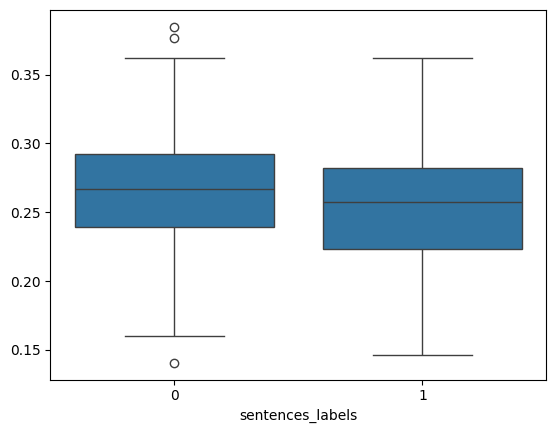

In [202]:
sns.boxplot(x=sentences_df['sentences_labels'], y=original_cosine_similarities)
plt.show()

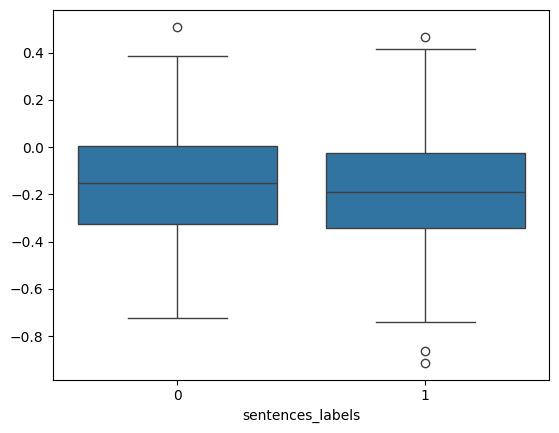

In [209]:
sns.boxplot(x=sentences_df['sentences_labels'], y=cosine_similarities_pca_concat.T[0])
plt.show()

In [210]:
sentence_vec_df = pd.DataFrame(sentence_reduced, columns=[f'sentence_vec_dim_{i+1}' for i in range(10)])
image_vec_df = pd.DataFrame(image_reduced, columns=[f'image_vec_dim_{i+1}' for i in range(10)])

sentence_df1 = pd.concat([sentences_df, sentence_vec_df, image_vec_df], axis=1)
sentence_df1

,image_link,description,hallucinations,logits,objects_num,words_logits_mapping,sentence,sentence_normalized_index,sentences_labels,sentence_contains_hedges,...,image_vec_dim_1,image_vec_dim_2,image_vec_dim_3,image_vec_dim_4,image_vec_dim_5,image_vec_dim_6,image_vec_dim_7,image_vec_dim_8,image_vec_dim_9,image_vec_dim_10
0,https://cdn.pixabay.com/photo/2021/12/18/06/01...,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...",14,"[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",The image depicts a lively street scene with ...,0.0,0,0,...,11.264843,0.217086,-7.307730,6.677151,-0.666669,-1.310044,5.133203,-1.017156,1.829398,-3.824579
1,https://cdn.pixabay.com/photo/2021/12/18/06/01...,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...",14,"[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",There are many people walking along the sidew...,0.166667,0,0,...,11.264843,0.217086,-7.307730,6.677151,-0.666669,-1.310044,5.133203,-1.017156,1.829398,-3.824579
2,https://cdn.pixabay.com/photo/2021/12/18/06/01...,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...",14,"[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",<0x0A><0x0A>Various modes of transportation ar...,0.333333,0,0,...,11.264848,0.217086,-7.307729,6.677150,-0.666668,-1.310044,5.133200,-1.017156,1.829400,-3.824580
3,https://cdn.pixabay.com/photo/2021/12/18/06/01...,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...",14,"[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...","The cars are lined up along the street, with ...",0.5,1,0,...,11.264848,0.217086,-7.307729,6.677150,-0.666668,-1.310044,5.133200,-1.017156,1.829400,-3.824580
4,https://cdn.pixabay.com/photo/2021/12/18/06/01...,The image depicts a lively street scene with ...,The image depicts a lively street scene with c...,"[( The, {'The': 0.9288, 'This': 0.0377, 'In': ...",14,"[(The, [0]), (image, [1]), (depicts, [2, 3, 4]...",The bicycle can be spotted on the left side o...,0.666667,0,1,...,11.264848,0.217086,-7.307729,6.677150,-0.666668,-1.310044,5.133200,-1.017156,1.829400,-3.824580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,https://cdn.pixabay.com/photo/2023/11/30/08/36...,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...",1,"[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",They are all wearing colorful or patterned dr...,0.166667,0,0,...,9.166765,12.414261,-5.829058,4.466972,6.497458,1.807796,-2.142888,-0.113205,1.922977,-1.278290
757,https://cdn.pixabay.com/photo/2023/11/30/08/36...,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...",1,"[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",The women appear to be deeply immersed in the...,0.333333,0,1,...,9.166765,12.414261,-5.829058,4.466972,6.497458,1.807796,-2.142888,-0.113205,1.922977,-1.278290
758,https://cdn.pixabay.com/photo/2023/11/30/08/36...,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...",1,"[(The, [0]), (image, [1]), (portrays, [2, 3, 4...",<0x0A><0x0A>There is a total of five women in ...,0.5,1,0,...,9.166769,12.414259,-5.829056,4.466971,6.497458,1.807795,-2.142886,-0.113208,1.922976,-1.278293
759,https://cdn.pixabay.com/photo/2023/11/30/08/36...,The image portrays a group of women sitting i...,The image portrays a group of women sitting in...,"[( The, {'The': 0.8759, 'In': 0.103, 'This': 0...",1,"[(The, [0]), (image, [1]), (portra

In [159]:
sentence_df1.to_pickle('sentences_df_with_pca.pkl')

In [211]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support


sentence_df1['contains_CD'] = sentence_df1['sentence_POS'].apply(lambda x: 'CD' in x).astype(int)
sentence_df1['contains_NNS'] = sentence_df1['sentence_POS'].apply(lambda x: 'NNS' in x).astype(int)
sentence_df1['contains_JJR'] = sentence_df1['sentence_POS'].apply(lambda x: 'JJR' in x).astype(int)


# Feature set and labels

# FEATURES = ['sentence_normalized_index', 'sentence_contains_hedges', 'sentence_len', 'mean_pos_prob', 'max_pos_prob', 'min_pos_prob', 'median_pos_prob',
#             'median_sentence_probes', 'mean_sentence_probes', 'min_sentence_probes', 'max_sentence_probes'] + [f'image_vec_dim_{i+1}' for i in range(10)] + [f'sentence_vec_dim_{i+1}' for i in range(10)]


FEATURES = [f'image_vec_dim_{i+1}' for i in range(10)] + [f'sentence_vec_dim_{i+1}' for i in range(10)]

LABEL = 'sentences_labels'

# feature_to_target_corr(sentences_df, FEATURES, LABEL, save_path="correlation_plot.png")

# Split the data into train and test sets
X = sentence_df1[FEATURES].astype(float)
y = sentence_df1[LABEL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForest classifier
# rf = RandomForestClassifier(random_state=42, min_samples_leaf=3)
model = xgb.XGBClassifier(n_estimators=200, max_depth=50, eta=0.05, gamma=0.1, reg_lambda=0.8, min_child_weight=2)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC score

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print detailed classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# Print individual metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)


Feature Importance:
                Feature  Importance
15   sentence_vec_dim_6    0.082268
16   sentence_vec_dim_7    0.059099
1       image_vec_dim_2    0.055300
11   sentence_vec_dim_2    0.053537
18   sentence_vec_dim_9    0.053349
6       image_vec_dim_7    0.053221
19  sentence_vec_dim_10    0.051476
10   sentence_vec_dim_1    0.050798
2       image_vec_dim_3    0.049292
7       image_vec_dim_8    0.048870
12   sentence_vec_dim_3    0.047789
4       image_vec_dim_5    0.046449
0       image_vec_dim_1    0.046197
3       image_vec_dim_4    0.044530
14   sentence_vec_dim_5    0.043870
8       image_vec_dim_9    0.043667
13   sentence_vec_dim_4    0.042846
17   sentence_vec_dim_8    0.042651
9      image_vec_dim_10    0.042404
5       image_vec_dim_6    0.042388

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.63        81
           1       0.59      0.64      0.61        72

    accuracy                       